In [ ]:
from MR_env import MR_env
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

PREDICTIONS OF $S_t$

In [ ]:
learning_rate = 0.001

input_size = 1  # Number of features in each time step of the input sequence
sequence_length = 100  # Number of time steps in each input sequence
batch_size = 256*2  # Number of input sequences processed together in each training iteration
hidden_size = 30  # Number of units in the hidden state of the GRU layer
output_size = 1  # Number of output units
num_layers = 5  # Number of layers in the GRU layer 
num_epochs = 200  # Number of training iterations

env = MR_env(S_0=1, kappa=1, sigma=0.3, theta=1, dt=0.1, T = int(10), I_max=sequence_length, lambd=0.05)

S, _ = env.Randomize_Start(batch_size)

lag = sequence_length
X = S[:,:-1]
Y = S[:,-1:]


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nl):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers=nl , batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) #more linear layers + activation 

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take only the last step output
        return out

model = GRUModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
mean = X.mean().numpy()
std = X.std().numpy()

In [ ]:
x_nrom = (X - mean)/std
y_nrom = (Y - mean)/std

In [ ]:
# Training the model
for epoch in range(num_epochs):
    # Forward pass
    #####
    outputs = model(x_nrom.reshape(batch_size,-1,1).float()      )
    loss = criterion(outputs, y_nrom)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    torch.save(model, 'model.pth')


In [ ]:
modello = torch.load('model.pth')

In [ ]:
env = MR_env(S_0=1, kappa=1, sigma=0.3, theta=1, dt=0.1, T = int(10), I_max=sequence_length, lambd=0.05)

S_1, _ = env.Randomize_Start(batch_size)

lag = sequence_length
X_test= S_1[:,:-1]
Y_test= S_1[:,-1:]

x_test_nrom = (X_test - mean)/std     
y_test_nrom = (Y_test - mean)/std

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = modello(x_test_nrom.view(batch_size,sequence_length,1).float())     # Here we use the same input shape as the training phase


In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot( (y_test_nrom*std + mean), label='Original Data')
plt.plot( (y_pred*std+ mean), label='Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GRU Prediction on Time Series Data')
plt.legend()
plt.show()

In [ ]:
X_test[:,-1], Y_test

In [ ]:
plt.plot((X_test[:,-1]).numpy(),label= 'naive pred')
plt.plot((y_test_nrom*std + mean), label='original data')
plt.legend()
;

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
mean_squared_error((y_test_nrom*std + mean).numpy(), (y_pred*std+ mean).numpy()), mean_squared_error((X_test[:,-1]).numpy().flatten(), (y_pred*std+ mean).numpy())

In [ ]:
def r_squared(y_true, y_pred):
    # Calculate the mean of the true values
    y_mean = np.mean(y_true)
    
    # Calculate the total sum of squares
    ss_total = np.sum((y_true - y_mean)**2)
    
    # Calculate the residual sum of squares
    ss_residual = np.sum((y_true - y_pred)**2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2

In [ ]:

(y_pred.numpy()*Y_test.std().numpy()+ Y_test.mean().numpy())


In [ ]:
import seaborn as sns
sns.histplot( (Y_test.numpy().flatten()  - (X_test[:,-1]).numpy() ).flatten()  , kde=True, label='naive pred' , color = 'r' );   
sns.histplot( (Y_test.numpy().flatten() -  (y_pred.numpy()*std + mean).flatten()) , kde=True, label='model pred')
plt.legend()
;

In [ ]:
y_nrom.shape, x_nrom.shape

In [ ]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.layers = nn.ModuleList([nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)  # Last layer without activation function for regression tasks
        return x


In [ ]:
10/0.1

In [ ]:
STOP

PREDICTIONS OF $\Delta S_t$

In [ ]:
from MR_env import MR_env
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

In [ ]:
learning_rate = 0.001
T = int(10)
dt = 0.1
input_size = 1  # Number of features in each time step of the input sequence
sequence_length = int(T/dt)  # Number of time steps in each input sequence
batch_size = 128  # Number of input sequences processed together in each training iteration
sch_epoch = 50
hidden_size = 30  # Number of units in the hidden state of the GRU layer
output_size = 1  # Number of output units
num_layers = 5  # Number of layers in the GRU layer 
num_epochs = 100  # Number of training iterations
decay_rate = 0.1 # lr scheduler decay rate
dropout_rate = 0.7 # dropout rate   
env = MR_env(S_0=1, kappa=1, sigma=0.3, theta=1, dt=dt, T = T, I_max=sequence_length, lambd=0.05)
np.random.seed(42)  
torch.manual_seed(42)
train = True
def grab_data(batch_size, x_min, x_max, y_min, y_max):
    S, _ = env.Randomize_Start(batch_size)
    X = S[:,:-1]
    Y = S[:,-1:]#torch.tensor(np.diff(S))[:,-1:]
    x_nrom = 2*(X - x_min)/(x_max - x_min )-1
    y_nrom = 2*(Y - y_min)/(y_max - y_min )-1
    
    return x_nrom, y_nrom

In [ ]:
class GRUModel_diff(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.0):
        super(GRUModel_diff, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second additional linear layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output linear layer

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = F.leaky_relu(self.fc1(out[:, -1, :]))
        #out = F.leaky_relu(self.fc2(out))  # Only take the output of the last time step
        out = self.fc3(out)
        return out
    
class LossCallback:
    def __init__(self):
        self.losses = []

    def __call__(self, loss):
        self.losses.append(loss)
        print(f'Loss: {loss:.4f}')


class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f'Early stopping after {self.counter} epochs of no improvement.')
                return True  # Stop training
        return False  # Continue training

model_diff = GRUModel_diff(input_size, hidden_size, output_size, num_layers, dropout_rate = dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_diff.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = decay_rate)

In [ ]:
# Training the model

losses = []
loss_callback = LossCallback()
early_stopping = EarlyStopping(patience=100)
batch_size = batch_size
S, _ = env.Randomize_Start(batch_size)
X = S[:,:-1]
Y = S[:, -1:]#]torch.tensor(np.diff(S))[:,-1:]
x_min, x_max = X.min(), X.max()
y_min, y_max = X.min(), X.max() #Y.mean(), Y.std()

if train == True:

    for epoch in range(num_epochs):
        # Forward pass
        x_nrom, y_nrom = grab_data(batch_size,  x_min, x_max, y_min, y_max)
        
        for i in range(0,len(x_nrom), batch_size):
            outputs = model_diff(x_nrom.reshape(batch_size, sequence_length ,input_size).float())
            loss = criterion(y_nrom, outputs)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if epoch == 0 or (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        if early_stopping(loss.item()):
            break   

        #torch.save(model_diff, 'model_diff_theta_fixed.pth')    
        # Step the learning rate scheduler
        #if (epoch+1) % sch_epoch == 0:
        #    scheduler.step()
        
    plt.plot(losses);

else:

    model_diff = torch.load('model_diff_theta_fixed.pth')

In [ ]:

S_1, _ = env.Randomize_Start(batch_size)

lag = sequence_length
X_test = S_1[:,:-1]
Y_test = S_1[:,-1:]#torch.tensor(np.diff(S_1))[:,-1:]

x_test_nrom = 2*(X - x_min)/(x_max - x_min )-1
y_test_nrom = 2*(Y - y_min)/(y_max - y_min )-1


In [ ]:
#model_diff = torch.load('model_diff_theta_fixed.pth')
model_diff.eval()
with torch.no_grad():
    y_pred = model_diff(x_test_nrom.reshape(x_test_nrom.shape[0], (sequence_length), input_size))     # Here we use the same input shape as the training phase


In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot( (((y_pred  )* (x_max - x_min) + x_min)).numpy().flatten()  , label='Predicted Data')
plt.plot( Y_test, label='Original Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GRU Prediction on Time Series Data')
plt.legend()
plt.show()

In [ ]:
Y_test

In [ ]:
plt.plot((X_test[:,-2].numpy()),label= 'naive pred')
plt.plot(Y_test, label='original data')
plt.legend()
;

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
(mean_squared_error(Y_test.numpy(),((y_pred * (x_max - x_min)  + x_min)) )), (mean_squared_error(Y_test.numpy(),(X_test[:,-50].numpy())))

In [ ]:
((X_test[:,-1].numpy()).flatten()- Y_test.numpy().flatten() ).mean()

In [ ]:
(Y_test.numpy()-(((y_pred  + 1)* (x_max - x_min) / 2 + x_min)).numpy().flatten()).mean()

In [ ]:
import seaborn as sns
sns.histplot( (Y_test.numpy().flatten()  - (X_test[:,-1]).numpy() ).flatten()  , kde=True, label='naive pred' , color = 'r' );   
sns.histplot(  Y_test.numpy().flatten()  - (((y_pred )* (x_max - x_min) + x_min)).numpy().flatten()    , kde=True, label='model pred')
plt.legend()
;

In [ ]:
#x_original = (x_normalized + 1) * (x_max - x_min) / 2 + x_min


In [ ]:
STOP

Multi-step presdictions of $\Delta S_t$

In [1]:
from MR_env import MR_env
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

In [2]:
learning_rate = 0.001
T = int(10)# * 2
dt = 0.1
input_size = 1  # Number of features in each time step of the input sequence
sequence_length = 100#int(T/dt/2)  # Number of time steps in each input sequence
batch_size = 1024  # Number of input sequences processed together in each training iteration
sch_epoch = 150
hidden_size = 30  # Number of units in the hidden state of the GRU layer
output_size = 1#int(T/dt/2)  # Number of output units
num_layers = 10  # Number of layers in the GRU layer 
num_epochs = 500  # Number of training iterations
decay_rate = 0.1 # lr scheduler decay rate
dropout_rate = 0.7 # dropout rate   
env = MR_env(S_0=1, kappa=1, sigma=0.3, theta=1, dt=dt, T = T, I_max=sequence_length, lambd=0.05)
np.random.seed(42)  
torch.manual_seed(42)
train = True





def grab_data(batch_size, x_min, x_max, y_min, y_max):
    S, _ = env.Randomize_Start(batch_size)
    X = S[:,:-1]
    Y = S[:,-1:]#torch.tensor(np.diff(S))
    x_nrom = (X - x_min)/( x_max - x_min )
    y_nrom = (Y - x_min)/( x_max - x_min )
    
    return x_nrom, y_nrom

In [3]:
class GRUModel_diff(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate=0.0):
        super(GRUModel_diff, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second additional linear layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output linear layer

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = F.tanh(self.fc2(out[:, -1, :]))  # Only take the output of the last time step
        out = self.fc3(out)
        return out
    
class LossCallback:
    def __init__(self):
        self.losses = []

    def __call__(self, loss):
        self.losses.append(loss)
        print(f'Loss: {loss:.4f}')


class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f'Early stopping after {self.counter} epochs of no improvement.')
                return True  # Stop training
        return False  # Continue training

model_diff = GRUModel_diff(input_size, hidden_size, output_size, num_layers, dropout_rate = dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_diff.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = decay_rate)

In [4]:
# Training the model

losses = []
loss_callback = LossCallback()
early_stopping = EarlyStopping(patience=100)
batch_size = batch_size
S, _ = env.Randomize_Start(batch_size)
X = S[:,:-1]
Y = S[:,-1:]#torch.tensor(np.diff(S))
x_min = X.min()
x_max = X.max()
y_min = X.min()
y_max = X.max()


Epoch [10/500], Loss: 0.0701
Epoch [20/500], Loss: 0.0439
Epoch [30/500], Loss: 0.0317
Epoch [40/500], Loss: 0.0265
Epoch [50/500], Loss: 0.0233
Epoch [60/500], Loss: 0.0242
Epoch [70/500], Loss: 0.0191
Epoch [80/500], Loss: 0.0197
Epoch [90/500], Loss: 0.0199
Epoch [100/500], Loss: 0.0171
Epoch [110/500], Loss: 0.0163
Epoch [120/500], Loss: 0.0183
Epoch [130/500], Loss: 0.0168
Epoch [140/500], Loss: 0.0157
Epoch [150/500], Loss: 0.0157
Epoch [160/500], Loss: 0.0157
Epoch [170/500], Loss: 0.0141
Epoch [180/500], Loss: 0.0159
Epoch [190/500], Loss: 0.0145
Epoch [200/500], Loss: 0.0145
Epoch [210/500], Loss: 0.0144
Epoch [220/500], Loss: 0.0124
Epoch [230/500], Loss: 0.0137
Epoch [240/500], Loss: 0.0122
Epoch [250/500], Loss: 0.0109
Epoch [260/500], Loss: 0.0073
Epoch [270/500], Loss: 0.0069
Epoch [280/500], Loss: 0.0065
Epoch [290/500], Loss: 0.0059
Epoch [300/500], Loss: 0.0056
Epoch [310/500], Loss: 0.0056
Epoch [320/500], Loss: 0.0057
Epoch [330/500], Loss: 0.0056
Epoch [340/500], Lo

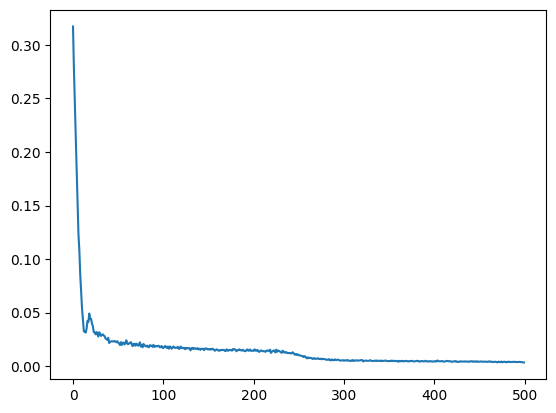

In [5]:
if train == True:
    for epoch in range(num_epochs):
        # Forward pass
        x_nrom, y_nrom = grab_data(batch_size, x_min ,x_max ,y_min ,y_max)
        for i in range(0,len(x_nrom), batch_size):
            outputs = model_diff(x_nrom.reshape(batch_size, sequence_length ,input_size).float())
            loss = criterion(y_nrom, outputs)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        if early_stopping(loss.item()):
            break   

        #torch.save(model_diff, 'model_diff_theta_fixed_multi.pth')    
        # Step the learning rate scheduler
        #if (epoch+1) % sch_epoch == 0:
        #    scheduler.step()
        
    plt.plot(losses);
else:
    model_diff = torch.load('model_diff_theta_fixed_multi.pth')

In [6]:

S_1, _ = env.Randomize_Start(batch_size)

lag = sequence_length
X_test = S_1[:,:-1]
Y_test = S_1[:,-1:]#torch.tensor(np.diff(S_1))

x_test_nrom = (X_test - x_min)/(x_max - x_min) 
y_test_nrom = (Y_test - x_min)/( x_max - x_min )


In [7]:
#model_diff = torch.load('model_diff_theta_fixed.pth')
model_diff.eval()
with torch.no_grad():
    y_pred = model_diff(x_test_nrom.reshape(x_test_nrom.shape[0], (sequence_length), input_size))     # Here we use the same input shape as the training phase


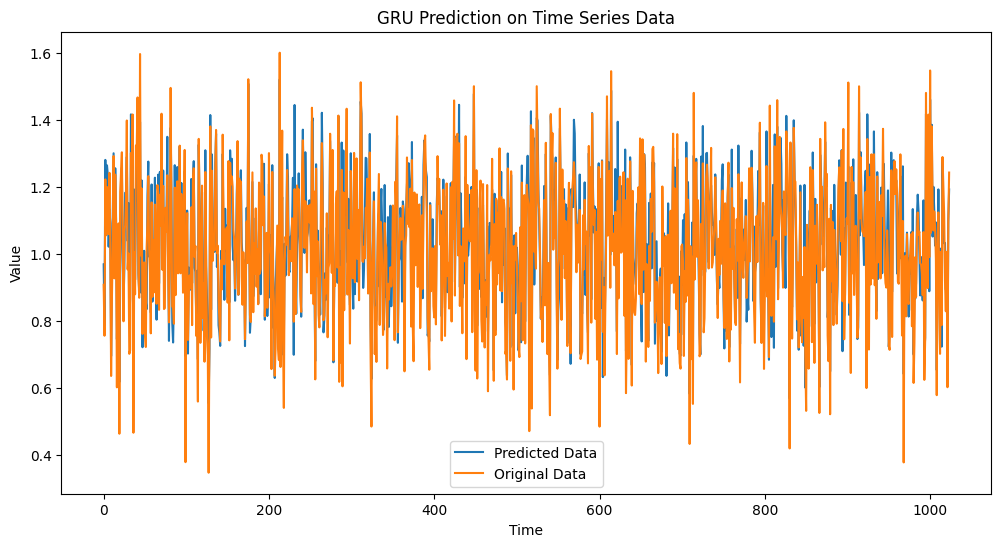

In [8]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot( (((y_pred)* (x_max - x_min) + x_min)).numpy()  , label='Predicted Data')
plt.plot( Y_test, label='Original Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GRU Prediction on Time Series Data')
plt.legend()
plt.show()

''

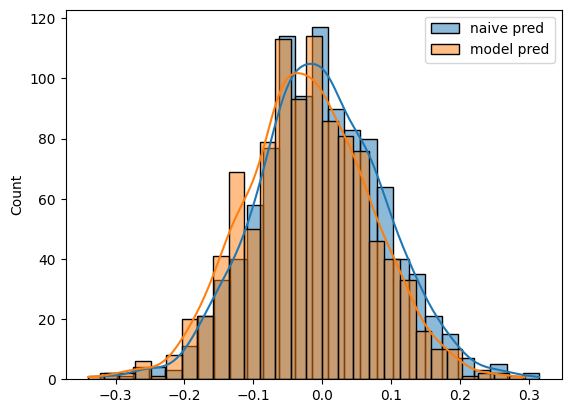

In [9]:
import seaborn as sns
sns.histplot( (Y_test.numpy() -(X_test[:,-1:]).numpy() ).flatten()  , kde=True, label='naive pred'  );   
sns.histplot(( Y_test.numpy()-((y_pred)*(y_max - y_min)+ y_min ).numpy()).flatten()    , kde=True, label='model pred')
plt.legend()
;

In [10]:
from sklearn.metrics import mean_squared_error
print('GRU RMSE =',(mean_squared_error(Y_test.numpy()  ,((y_pred)*(y_max - y_min) + y_min).numpy())), ',  Naive RMSE =',(mean_squared_error(Y_test.numpy()  , (X_test[:,-1]) )))

GRU RMSE = 0.008793641 ,  Naive RMSE = 0.008606581


''

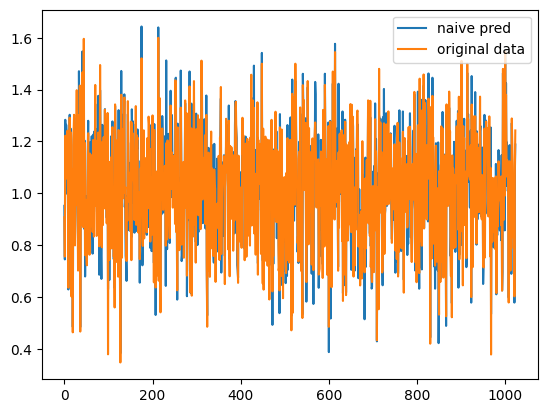

In [11]:
plt.plot((X_test[:,-1].numpy()),label= 'naive pred')
plt.plot(Y_test, label='original data')
plt.legend()
;

In [12]:
#torch.save(model_diff, 'eliciting_model_s_t_plus_one.pth')

: 